#### New to Plotly?
Plotly's Python library is free and open source! [Get started](https://plot.ly/python/getting-started/) by downloading the client and [reading the primer](https://plot.ly/python/getting-started/).
<br>You can set up Plotly to work in [online](https://plot.ly/python/getting-started/#initialization-for-online-plotting) or [offline](https://plot.ly/python/getting-started/#initialization-for-offline-plotting) mode, or in [jupyter notebooks](https://plot.ly/python/getting-started/#start-plotting-online).
<br>We also have a quick-reference [cheatsheet](https://images.plot.ly/plotly-documentation/images/python_cheat_sheet.pdf) (new!) to help you get started!

#### Overview
This notebook demonstrates how to use DataShader to display large datasets inside a plotly `FigureWidget`. Change callbacks are used to recompute the datashader image whenever the axis range or figure size changes

#### Imports

In [2]:
# core
import io
import base64 
import time

# pandas
import pandas as pd

# numpy
import numpy as np

# scikit learn
from sklearn import datasets

# datashader
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import inferno

#### Generate dataset
We will create a large dataset by duplicating the Iris dataset many times with random noise

In [3]:
num_copies = 7000 # 1,050,000 rows

iris_data = datasets.load_iris()
feature_names = [name.replace(' (cm)', '').replace(' ', '_') for name in iris_data.feature_names]
iris_df_orig = pd.DataFrame(iris_data.data, columns=feature_names)
target_orig = iris_data.target + 1

# frame of features
iris_df = pd.concat(
    np.random.normal(scale=0.2, size=iris_df_orig.shape) + iris_df_orig for i in range(num_copies)
).reset_index(drop=True)

# array of targets
target = [t for i in range(num_copies) for t in target_orig]

# dataframe that includes target as categorical
iris_target_df = pd.concat([iris_df, pd.Series(target, name='target', dtype='category')], axis=1)

iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,1.050000e+06,1.050000e+06,1.050000e+06,1.050000e+06
mean,5.843322e+00,3.053826e+00,3.758637e+00,1.198662e+00
std,8.488862e-01,4.761369e-01,1.769910e+00,7.865315e-01
min,3.513149e+00,1.299055e+00,3.115114e-01,-6.631019e-01
25%,5.156767e+00,2.740113e+00,1.636770e+00,3.929785e-01
50%,5.801633e+00,3.033015e+00,4.306745e+00,1.316042e+00
75%,6.443514e+00,3.345643e+00,5.143670e+00,1.827473e+00
max,8.598814e+00,5.109186e+00,7.763358e+00,3.267767e+00


#### Define DataShader image generation function
Define a function that inputs an x/y ranges and the plot width/height and generates a DataShader image of the dataset.  The image will be returned as a PIL image object

In [4]:
def gen_ds_image(x_range, y_range, plot_width, plot_height):
    if x_range is None or y_range is None or plot_width is None or plot_height is None:
        return None
    
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=plot_height, plot_width=plot_width)
    agg_scatter = cvs.points(iris_target_df, 
                         'sepal_length', 'sepal_width', 
                          ds.count_cat('target'))
    img = tf.shade(agg_scatter)
    img = tf.dynspread(img, threshold=0.95, max_px=5, shape='circle')
    
    return img.to_pil()

#### Define initial ranges and plot size

In [5]:
x_range=[3, 10]
y_range=[0, 6]
plot_height=500
plot_width=700

In [6]:
# Test image generation function and display the PIL image
initial_img = gen_ds_image(x_range, y_range, plot_width, plot_height)

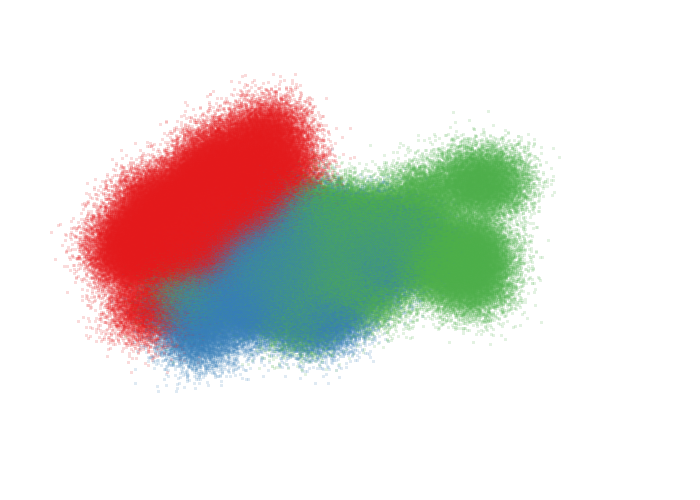

In [7]:
initial_img

#### Create FigureWidget with background image

In [8]:
import plotly.graph_objs as go

In [ ]:
f = go.FigureWidget(data=[{'x': x_range, 
                           'y': y_range, 
                           'mode': 'markers',
                           'marker': {'opacity': 0}}], # invisible trace to init axes and to support autoresize
                    layout={'width': plot_width, 'height': plot_height})
f

In [10]:
# Set background image
f.layout.images = [go.layout.Image(
    source = initial_img,  # plotly now performs auto conversion of PIL image to png data URI
    xref = "x",
    yref = "y",
    x = x_range[0],
    y = y_range[1],
    sizex = x_range[1] - x_range[0],
    sizey = y_range[1] - y_range[0],
    sizing = "stretch",
    layer = "below")]

#### Install change callback to update image on zoom/resize

In [11]:
def update_ds_image(layout, x_range, y_range, plot_width, plot_height):
    img = f.layout.images[0]
    
    # Update with batch_update so all updates happen simultaneously
    with f.batch_update():
        img.x = x_range[0]
        img.y = y_range[1]
        img.sizex = x_range[1] - x_range[0]
        img.sizey = y_range[1] - y_range[0]
        img.source = gen_ds_image(x_range, y_range, plot_width, plot_height)

# Install callback to run exactly once if one or more of the following properties changes
#  - xaxis range
#  - yaxis range
#  - figure width
#  - figure height
f.layout.on_change(update_ds_image, 'xaxis.range', 'yaxis.range', 'width', 'height')

#### Image updates on drag zoom

In [ ]:
f.layout.dragmode = 'zoom'
f

<img src='https://raw.githubusercontent.com/michaelbabyn/plot_data/master/datashader_figurewidget.gif'>

#### Reference

See [these Jupyter notebooks](https://github.com/jonmmease/plotly_ipywidget_notebooks) for even more FigureWidget examples.

In [2]:
from IPython.display import display, HTML

display(HTML('<link href="//fonts.googleapis.com/css?family=Open+Sans:600,400,300,200|Inconsolata|Ubuntu+Mono:400,700" rel="stylesheet" type="text/css" />'))
display(HTML('<link rel="stylesheet" type="text/css" href="http://help.plot.ly/documentation/all_static/css/ipython-notebook-custom.css">'))

! pip install git+https://github.com/plotly/publisher.git --upgrade
    
import publisher
publisher.publish(
    'change-callbacks-datashader.ipynb', 'python/change-callbacks-datashader/', 'FigureWidget | plotly',
    'Display Large Datasets with DataShader and Change Callbacks',
    title = 'DataShader Case Study',
    name = 'DataShader Case Study',
    uses_plotly_offline=True,
    has_thumbnail='true', thumbnail='thumbnail/figurewidget-datashader.gif', 
    language='python', 
    display_as='chart_events', order=24,
    ipynb= '~notebook_demo/239')

  Cloning https://github.com/plotly/publisher.git to /tmp/pip-req-build-MGM4eC
  Running setup.py bdist_wheel for publisher ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-yx3xDQ/wheels/99/3e/a0/fbd22ba24cca72bdbaba53dbc23c1768755fb17b3af0f33966
Successfully built publisher
  Found existing installation: publisher 0.11
    Uninstalling publisher-0.11:
      Successfully uninstalled publisher-0.11
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
